# <font color=darkblue> Machine Learning model deployment with Flask framework on Heroku</font>

## <font color=Blue>Used Cars Price Prediction Application</font>

### Objective:
1. To build a Machine learning regression model to predict the selling price of the used cars based on the different input features like fuel_type, kms_driven, type of transmission etc.
2. Deploy the machine learning model with flask framework on heroku.

### Dataset Information:
#### Dataset Source: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=CAR+DETAILS+FROM+CAR+DEKHO.csv
This dataset contains information about used cars listed on www.cardekho.com
- **Car_Name**: Name of the car
- **Year**: Year of Purchase
- **Selling Price (target)**: Selling price of the car in lakhs
- **Present Price**: Present price of the car in lakhs
- **Kms_Driven**: kilometers driven
- **Fuel_Type**: Petrol/diesel/CNG
- **Seller_Type**: Dealer or Indiviual
- **Transmission**: Manual or Automatic
- **Owner**: first, second or third owner


### 1. Import required libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

### 2. Load the dataset

In [21]:
df = pd.read_csv('car+data.csv')

### 3. Check the shape and basic information of the dataset.

In [22]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


**"Selling\_Price" will be the dependent variable and the rest of the variables will be considered as independent variables.**



In [23]:
df.shape

(301, 9)

**The dataset contains 301 samples and 9 columns.**


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


**Numerical Columns Description:**


In [25]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


**Object Columns Description:**


In [26]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


### 4. Check for the presence of the duplicate records in the dataset? If present drop them



In [27]:
df[df.duplicated(keep=False)]

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0


**Dropping duplicates:**


In [28]:
df.drop_duplicates(keep=False, inplace=True)
df[df.duplicated(keep=False)]

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner


**No duplicates left.**


### 5. Drop the columns which you think redundant for the analysis.

In [29]:
df.drop('Car_Name', axis=1, inplace=True)
df.head(5)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### 6. Extract a new feature called 'age_of_the_car' from the feature 'year' and drop the feature year

In [30]:
from datetime import datetime
from datetime import date

def calc_age(year):
    today=date.today()
    return today.year - year

df['age_of_the_car'] = df['Year'].apply(calc_age)
df.drop('Year', axis=1, inplace=True)

df.head(5)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,age_of_the_car
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


### 7. Encode the categorical columns

**Categorical columns:**


In [31]:
df.describe(include='object')

,Fuel_Type,Seller_Type,Transmission
count,297,297,297
unique,3,2,2
top,Petrol,Dealer,Manual
freq,239,191,259


**Implementing manual encoding on categorical columns:**

In [32]:
df['Fuel_Type'].unique()

array(['Petrol', 'Diesel', 'CNG'], dtype=object)

In [33]:
df['Seller_Type'].unique()

array(['Dealer', 'Individual'], dtype=object)

In [34]:
df['Transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [35]:
df['Fuel_Type'] = df['Fuel_Type'].replace({'Petrol':0, 'Diesel':1, 'CNG':2})

df['Seller_Type'] = df['Seller_Type'].replace({'Dealer':0, 'Individual':1})

df['Transmission'] = df['Transmission'].replace({'Manual':0, 'Automatic':1})

df.head(5)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,age_of_the_car
0,3.35,5.59,27000,0,0,0,0,10
1,4.75,9.54,43000,1,0,0,0,11
2,7.25,9.85,6900,0,0,0,0,7
3,2.85,4.15,5200,0,0,0,0,13
4,4.60,6.87,42450,1,0,0,0,10


### 8. Separate the target and independent features.

**"Selling\_Price" will be the dependent variable and the rest of the variables will be considered as independent variables.**


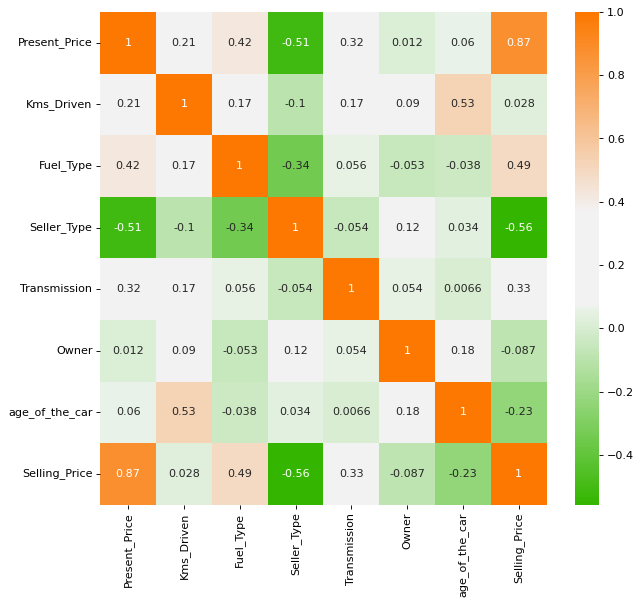

In [36]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df.drop(target,axis=1), df[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

- **The target variable "Selling Price" is highly correlated with Present\_Price & Seller\_Type & Fuel\_Type.**
- **Some independent variables like Fuel\_Type\_Petrol and Fuel\_Type\_Disel are highly correlated.**



### 9. Split the data into train and test.

**Determine Features & Target Variables**


In [37]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

**Split Dataset to Training & Test Sets:**


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (207, 7)
X_test shape:  (90, 7)
y_train shape:  (207,)
y_test shape:  (90,)


In [40]:
y_test_actual = y_test

**Scale Data using Standard Scaler:**


In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Train the Model:**


In [42]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

### 10. Build a Random forest Regressor model and check the r2-score for train and test.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_reg = RandomForestRegressor(n_estimators=100, random_state=0)
rf_reg.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=0)

**Predictions:**


In [44]:
y_pred_linear = linear_reg.predict(X_test_scaled)
y_pred_rf = rf_reg.predict(X_test_scaled)

**Calculate Mean Squared Error \(MSE\) and R\-squared \(R²\):**


In [45]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)

In [46]:
print("Linear Regression:")
print("MSE: ", mse_linear)
print("R²: ", r2_linear)

print("\nRandom Forest Regression:")
print("MSE: ", mse_rf)
print("R²: ", r2_rf)

Linear Regression:
MSE:  2.594363884282437
R²:  0.8624703841476833

Random Forest Regression:
MSE:  0.7559054458888903
R²:  0.9599287570168566


**Plot the results:**


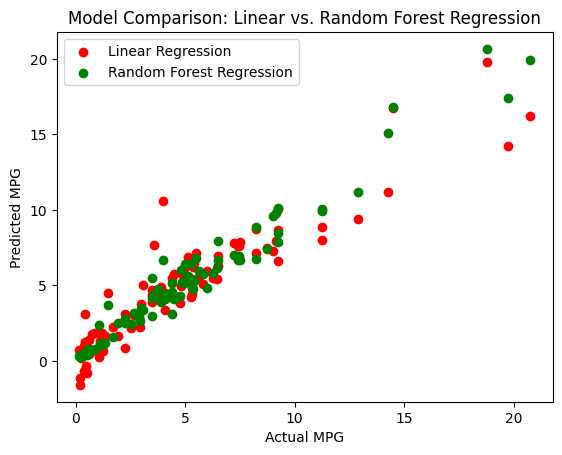

In [47]:
plt.scatter(y_test, y_pred_linear, label='Linear Regression', color='r')
plt.scatter(y_test, y_pred_rf, label='Random Forest Regression', color='g')
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.legend()
plt.title("Model Comparison: Linear vs. Random Forest Regression")
plt.show()

### 11. Create a pickle file with an extension as .pkl



In [48]:
import pickle

output = open('model.pkl', 'wb')
pickle.dump(rf_reg, output)
output.close()

### 12. Create new folder/new project in visual studio/pycharm that should contain the "model.pkl" file *make sure you are using a virutal environment and install required packages.*



### a) Create a basic HTML form for the frontend

Create a file **index.html** in the templates folder and copy the following code.

<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Document</title>
</head>

<body>

    <div class="hero-image">
      <div class="hero-text">

        <h1 style="font-size:50px">Used Car Price Predictor</h1>
         <br><br><h3>{{ prediction_text }}<h3>
      </div>
    </div>

     <style>

        body, html {
          height: 100%;
          margin: 0;
          font-family: Arial, Helvetica, sans-serif;
        }

        .hero-image {
          background-image: linear-gradient(rgba(0, 0, 0, 0.5), rgba(0, 0, 0, 0.5)), url('/static/image.jpg');
          height: 50%;
          background-position: bottom;
          background-repeat: no-repeat;
          background-size: cover;
          position: relative;
        }

        .hero-text {
          text-align: center;
          position: absolute;
          top: 50%;
          left: 50%;
          transform: translate(-50%, -50%);
          color: white;
        }

    </style>


    <div style="color:	rgb(0, 0, 0)">
        <form action="{{ url_for('predict')}}" method="post">
            <h2>Enter Car Details: </h2>
            <h3>Age of the car(In years)</h3>
            <input id="first" name="Age_of_the_car" type="number ">
            <h3>Present Showroom Price(In lakhs)</h3><br><input id="second" name="Present_Price" required="required">
            <h3>Kilometers Driven</h3><input id="third" name="Kms_Driven" required="required">
            <h3>Owner Type (0/1/3)</h3><br><input id="fourth" name="Owner" required="required">
            <h3>Fuel type</h3><br><select name="Fuel_Type" id="fuel" required="required">
                <option value="0">Petrol</option>
                <option value="1">Diesel</option>
                <option value="2">CNG</option>
            </select>
            <h3>Seller Type</h3><br><select name="Seller_Type" id="resea" required="required">
                <option value="0">Dealer</option>
                <option value="1">Individual</option>
            </select>
            <h3>Transmission type</h3><br><select name="Transmission" id="research" required="required">
                <option value="0">Manual Car</option>
                <option value="1">Automatic Car</option>
            </select>
            <br><br><button id="sub" type="submit ">Predict Selling Price</button>
            <br>


        </form>

    </div>

    <style>
	body {
            background-color: 101, 10, 20;
            text-align: center;
            padding: 0px;
	    font-family: Helvetica;
        }

        #research {
            font-size: 18px;
            width: 200px;
            height: 23px;
            top: 23px;
        }

        #box {
            border-radius: 60px;
            border-color: 45px;
            border-style: solid;
            text-align: center;
            background-color: white;
            font-size: medium;
            position: absolute;
            width: 700px;
            bottom: 9%;
            height: 850px;
            right: 30%;
            padding: 0px;
            margin: 0px;
            font-size: 14px;
        }

        #fuel {
            width: 83px;
            height: 43px;
            text-align: center;
            border-radius: 14px;
            font-size: 20px;
        }

        #fuel:hover {
            background-color: white;
        }

        #research {
            width: 150px;
            height: 43px;
            text-align: center;
            border-radius: 14px;
            font-size: 18px;
        }

        #research:hover {
            background-color: white;
        }

        #resea {
            width: 99px;
            height: 43px;
            text-align: center;
            border-radius: 14px;
            font-size: 18px;
        }

        #resea:hover {
            background-color: white;
        }

        #sub {
            background-color: Green;
            font-family:'Helvetica' monospace;
            font-weight: bold;
            width: 180px;
            height: 60px;
            text-align: center;
            border-radius: 20px;
            font-size: 18px;
            color: white;
        }

        #sub:hover {
            background-color: white;
        }

        #first {
            border-radius: 14px;
            height: 25px;
            font-size: 20px;
            text-align: center;
        }

        #second {
            border-radius: 14px;
            height: 25px;
            font-size: 20px;
            text-align: center;
        }

        #third {
            border-radius: 14px;
            height: 25px;
            font-size: 20px;
            text-align: center;
        }

        #fourth {
            border-radius: 14px;
            height: 25px;
            font-size: 20px;
            text-align: center;
        }
    </style>
</body>

</html>

### b) Create app.py file and write the predict function

from flask import Flask, render_template, request, jsonify
import pickle
import numpy as np
import sklearn


app = Flask(__name__)
model = pickle.load(open('model.pkl', 'rb'))


@app.route('/',methods=['GET'])
def Home():
    return render_template('index.html')


@app.route("/predict", methods=['POST'])
def predict():
    if request.method == 'POST':
        Present_Price=float(request.form['Present_Price'])
        Kms_Driven=int(request.form['Kms_Driven'])
        Owner=int(request.form['Owner'])
        Fuel_Type=request.form['Fuel_Type']
        Age_of_the_car=request.form['Age_of_the_car']
        Seller_Type=request.form['Seller_Type']
        Transmission=request.form['Transmission']

        prediction=model.predict([[Present_Price,Kms_Driven,Owner,Age_of_the_car,Fuel_Type,Seller_Type,Transmission]])
        output=round(prediction[0],2)
        return render_template('index.html',prediction_text="You can sell your car at {} lakhs".format(output))

if __name__=="__main__":
    app.run(debug=True)

### 13. Deploy your app on Heroku. (write commands for deployment)

Since Heroku platform no longers lets to host apps for free, the program manager told me to host the app on my local device and post screenshots of it here instead.

### 14. Paste the URL of the heroku application below, and while submitting the solution submit this notebook along with the source code.

# Deploying app on local server

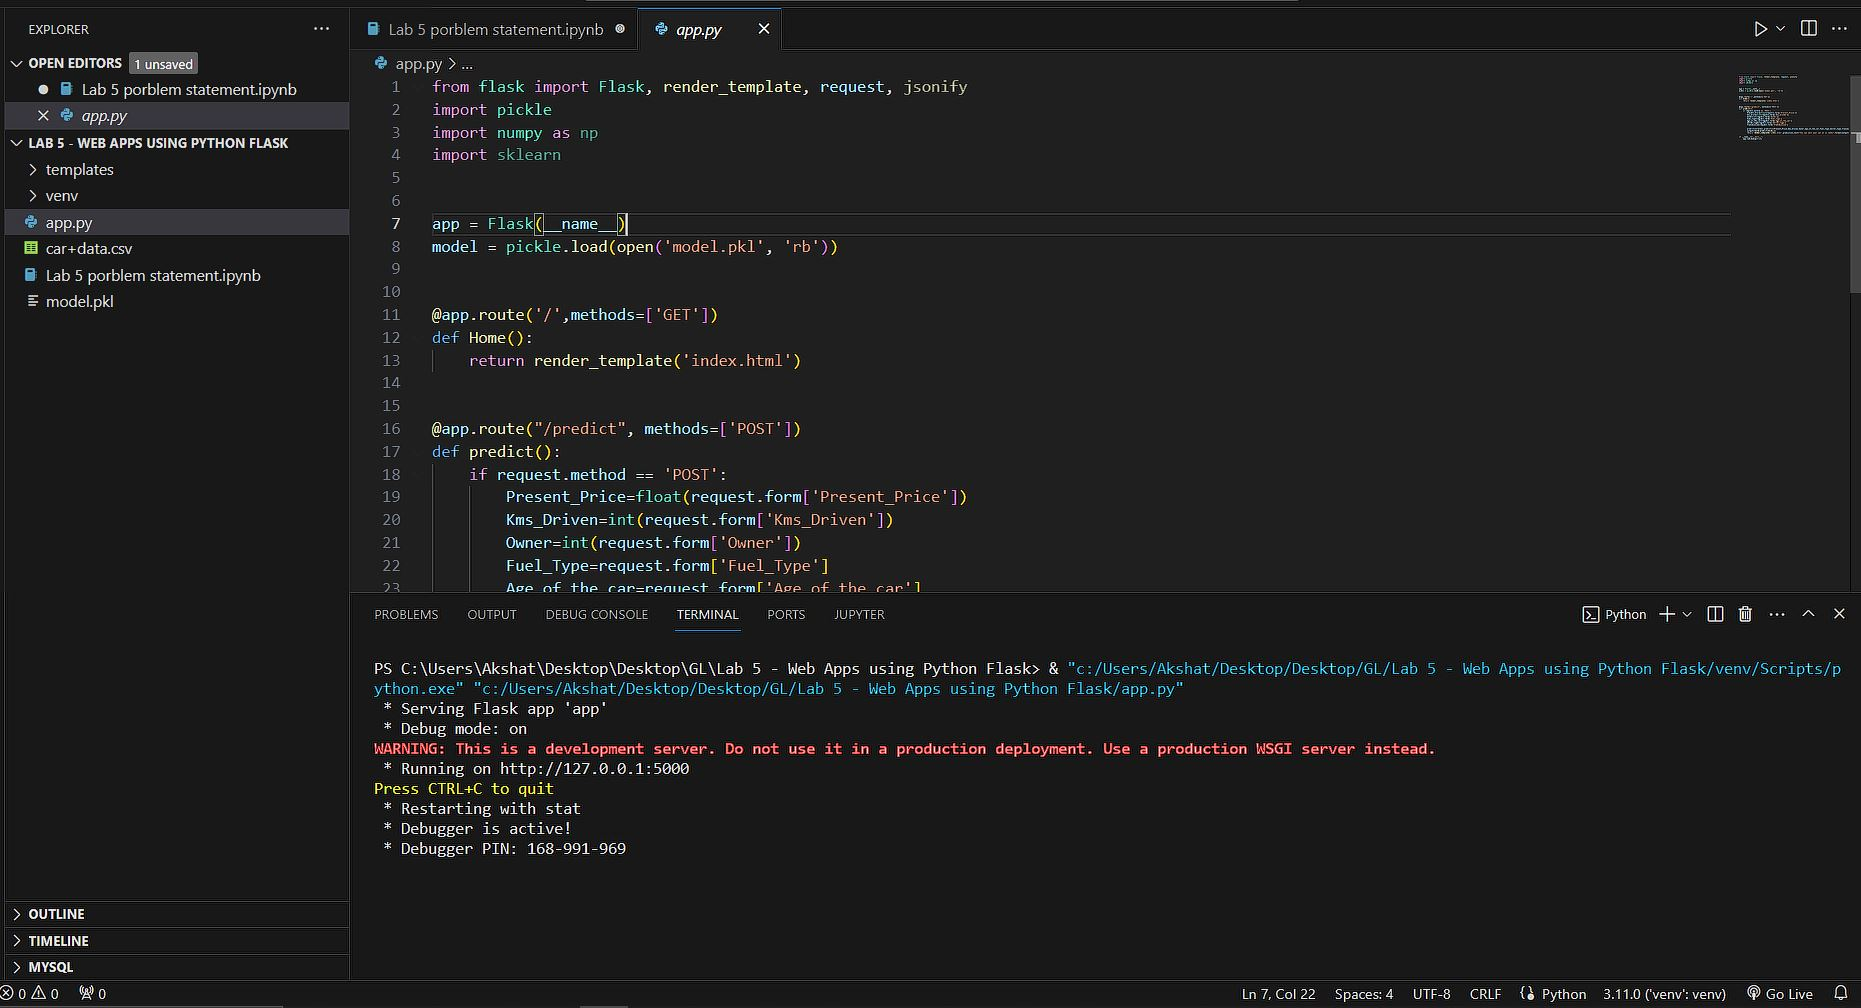

# Frontend form for the prediction app

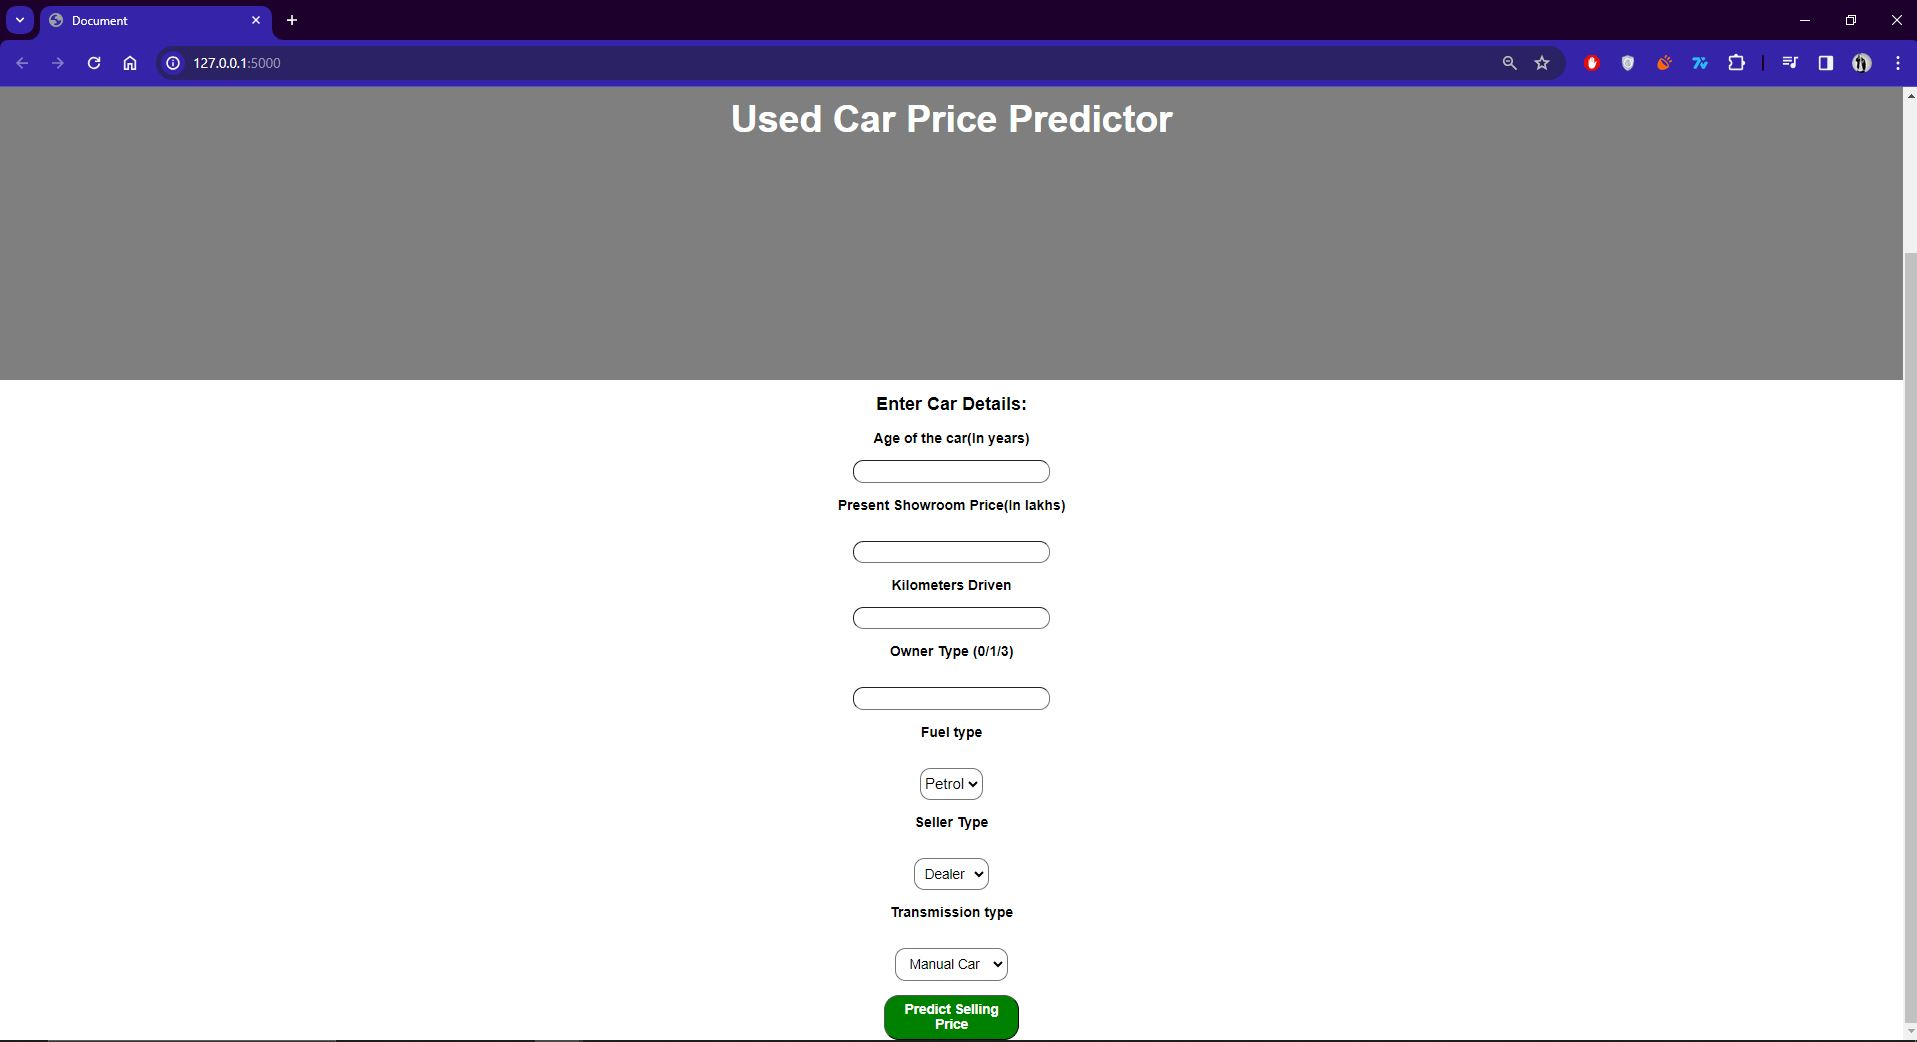

# Predicted selling price from the baackend prediction model

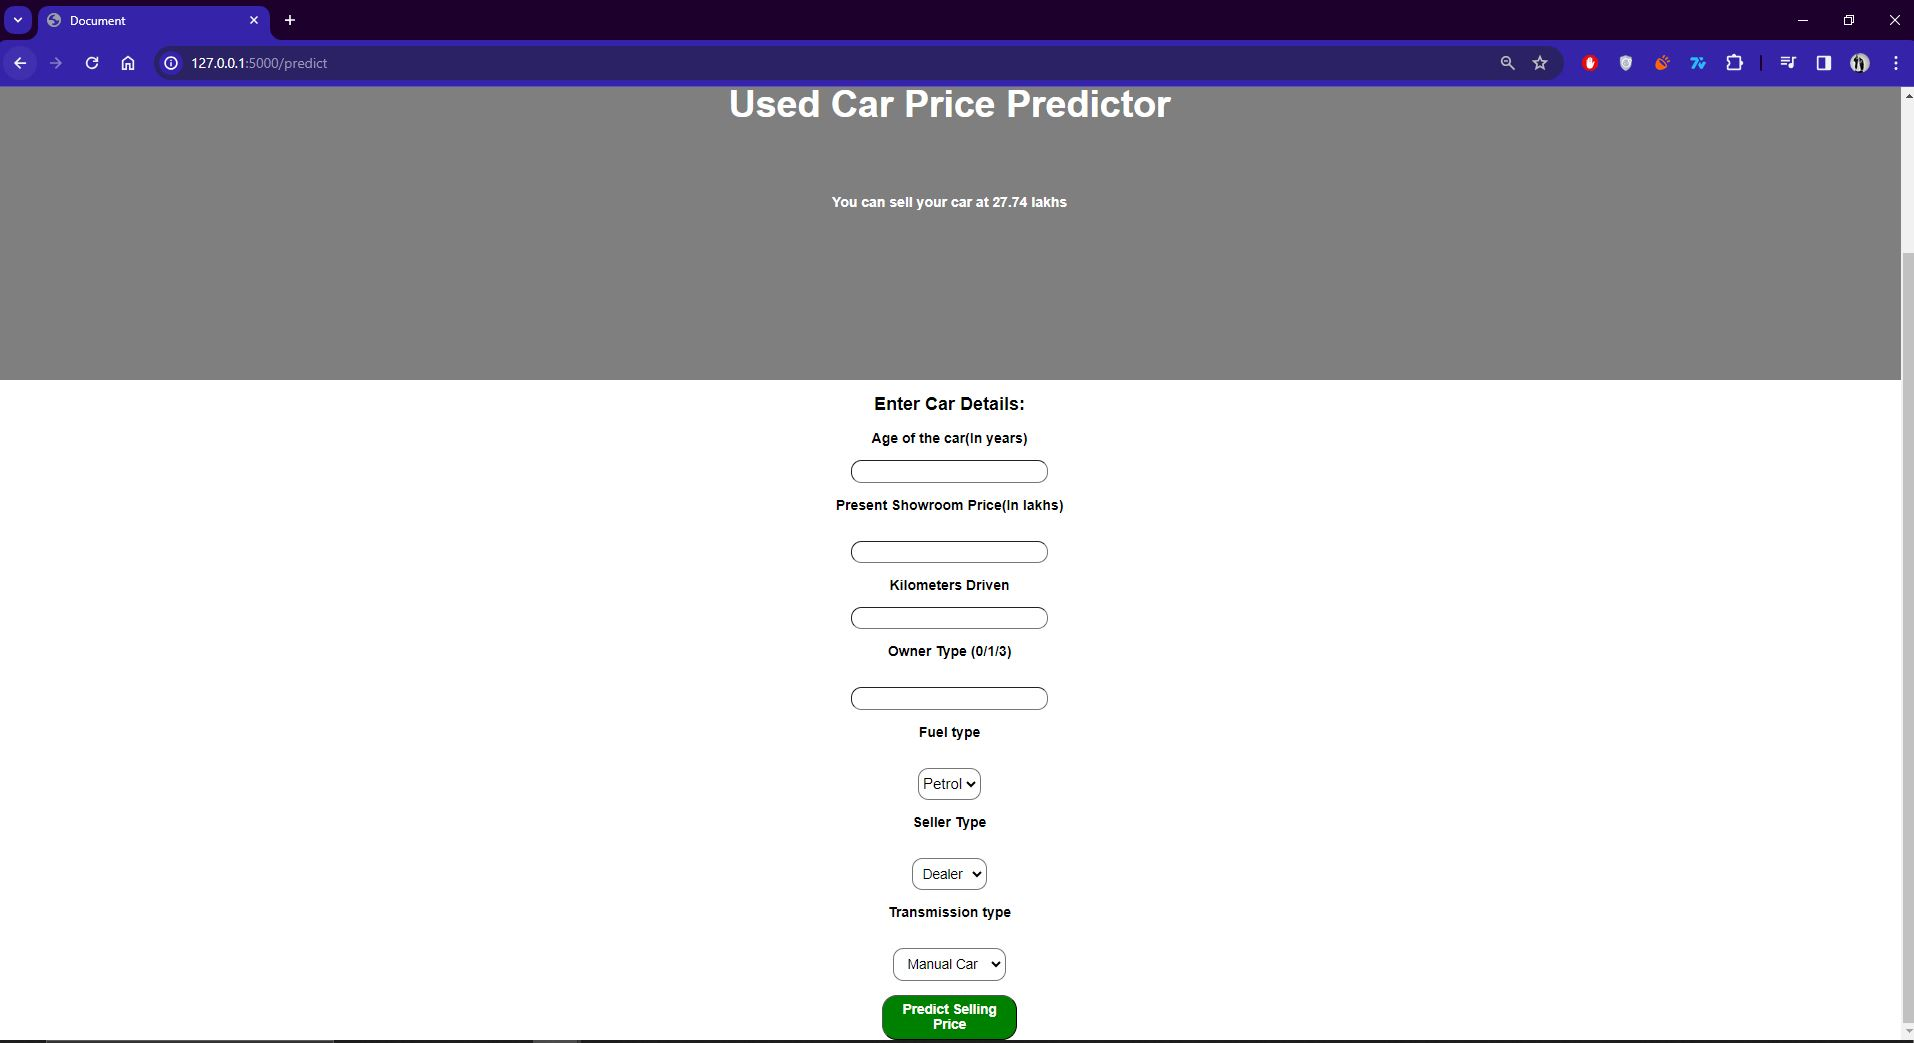

# Video of the app deployment process

<video src="Screenshots/bandicam%202024-01-20%2023-09-14-160.mp4" controls title="Title"></video>

# All 3 screenshots and video file is in Screenshots folder of the project.

### Happy Learning :)